# Étude sur MNIST

Commençons par importer les librairies nécessaires.

In [1]:
import copy
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from src.data import lire_mnist
from src.dnn import DNN

Importons les données.

In [18]:
data_train_path = "data/mnist_train.csv"
data_test_path = "data/mnist_test.csv"
X_train, y_train, X_test, y_test = lire_mnist(data_train_path, data_test_path)
print(f"X_train.shape = {X_train.shape}, y_train.shape = {y_train.shape}")
print(f"X_test.shape = {X_test.shape}, y_test.shape = {y_test.shape}")

X_train.shape = (60000, 784), y_train.shape = (60000, 10)
X_test.shape = (10000, 784), y_test.shape = (10000, 10)


## Utilitaire pour l'étude

In [23]:
def train_and_test(dnn, dnn_pretrained, X_train, y_train, X_test, y_test, learning_rate, batch_size, nb_epochs_pretraining, nb_epochs_retropropagation):
    start_time = time.time()
    losses = dnn.retropropagation(X_train, y_train, learning_rate, batch_size, nb_epochs_retropropagation, verbose=False)
    retropropagation_time = time.time() - start_time

    start_time = time.time()
    # dnn_pretrained.pretrain(X_train, learning_rate, batch_size, nb_epochs_pretraining, verbose=False)
    pretraining_time = time.time() - start_time
    start_time = time.time()
    losses_pretrained = None
    # losses_pretrained = dnn_pretrained.retropropagation(X_train, y_train, learning_rate, batch_size, nb_epochs_retropropagation, verbose=False)
    retropropagation_time_pretrained = time.time() - start_time

    acc = dnn.test(X_test, y_test)
    acc_pretrained = dnn_pretrained.test(X_test, y_test)

    print(f"Error rate without pretraining: {acc}")
    print(f"Error rate with pretraining: {acc_pretrained}")

    return acc, acc_pretrained, pretraining_time, retropropagation_time, retropropagation_time_pretrained, losses, losses_pretrained

## Étude du nombre de couches sur la performance

Nous allons comparer les performances de différents réseaux de neurones (pré-entrainés ou non) en fonction du nombre de couches.

In [9]:
nb_layers = [2, 3, 4, 5]
nb_neurons = 200
learning_rate = 0.1
batch_size = 100
nb_epochs_retropropagation = 100
nb_epochs_pretraining = 15

accuracies = []
accuracies_pretrained = []
times = []
times_pretrained = []

for nb_layer in nb_layers:
    print(f"\n##### nb_layer = {nb_layer}")
    dnn = DNN([784] + [nb_neurons for i in range(nb_layer)] + [10])
    dnn_pretrained = copy.deepcopy(dnn)

    acc, acc_pretrained, pretraining_time, retropropagation_time, retropropagation_time_pretrained, losses, losses_pretrained = train_and_test(
        dnn,
        dnn_pretrained,
        X_train,
        y_train,
        X_test,
        y_test,
        learning_rate,
        batch_size,
        nb_epochs_pretraining,
        nb_epochs_retropropagation,
    )

    accuracies.append(acc)
    accuracies_pretrained.append(acc_pretrained)
    times.append(retropropagation_time)
    times_pretrained.append(pretraining_time + retropropagation_time_pretrained)



##### nb_layer = 2


Retropropagation | Cross entropy loss: 0.0206 | Epoch: 100%|██████████| 100/100 [03:50<00:00,  2.30s/it]
DBN Training | RBM: 100%|██████████| 2/2 [01:15<00:00, 37.82s/it]
Retropropagation | Cross entropy loss: 0.0349 | Epoch: 100%|██████████| 100/100 [03:53<00:00,  2.34s/it]


Error rate without pretraining: 0.0268
Error rate with pretraining: 0.0232

##### nb_layer = 3


Retropropagation | Cross entropy loss: 0.0759 | Epoch: 100%|██████████| 100/100 [05:17<00:00,  3.17s/it]
DBN Training | RBM: 100%|██████████| 3/3 [01:57<00:00, 39.23s/it]
Retropropagation | Cross entropy loss: 0.0287 | Epoch: 100%|██████████| 100/100 [10:38<00:00,  6.39s/it]


Error rate without pretraining: 0.044
Error rate with pretraining: 0.0217

##### nb_layer = 4


Retropropagation | Cross entropy loss: 1.7488 | Epoch: 100%|██████████| 100/100 [52:20<00:00, 31.41s/it]   
DBN Training | RBM: 100%|██████████| 4/4 [02:10<00:00, 32.60s/it]
Retropropagation | Cross entropy loss: 0.0274 | Epoch: 100%|██████████| 100/100 [07:46<00:00,  4.67s/it]


Error rate without pretraining: 0.6709
Error rate with pretraining: 0.023

##### nb_layer = 5


Retropropagation | Cross entropy loss: 2.3014 | Epoch: 100%|██████████| 100/100 [09:02<00:00,  5.42s/it]
DBN Training | RBM: 100%|██████████| 5/5 [02:23<00:00, 28.79s/it]
Retropropagation | Cross entropy loss: 0.0254 | Epoch: 100%|██████████| 100/100 [09:01<00:00,  5.42s/it]


Error rate without pretraining: 0.8972
Error rate with pretraining: 0.0227


In [10]:
import pandas as pd

# create a dataframe with columns nb_layers, accuracy, time, pretrained
data = []
for i in range(len(nb_layers)):
    data.append([nb_layers[i], accuracies[i], times[i], False])
    data.append([nb_layers[i], accuracies_pretrained[i], times_pretrained[i], True])
df = pd.DataFrame(data, columns=["nb_layers", "accuracy", "time", "pretrained"])
df.head()

,nb_layers,accuracy,time,pretrained
0,2,0.0268,230.212061,False
1,2,0.0232,309.358760,True
2,3,0.0440,317.242876,False
3,3,0.0217,756.700304,True
4,4,0.6709,3140.739573,False


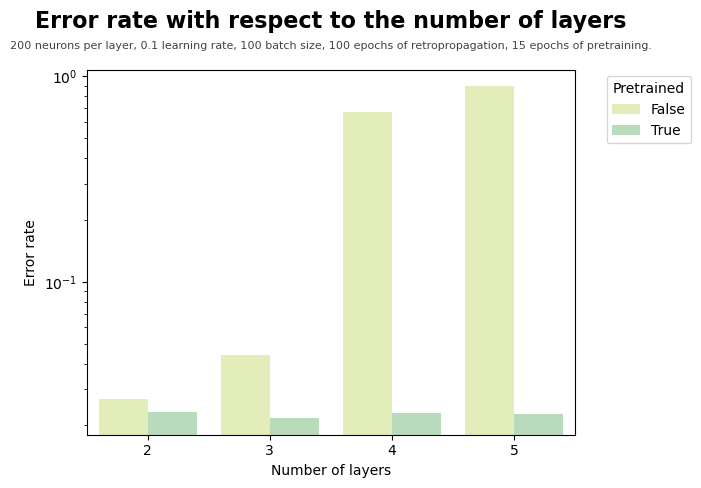

In [11]:
sns.set_palette(sns.color_palette("YlGnBu"))
fig, ax = plt.subplots(figsize=(7,5))
sns.barplot(
    x='nb_layers',
    y='accuracy',
    hue='pretrained',
    data=df,
    ax=ax
)

# make adjustments
ax.set_xlabel('Number of layers')
ax.set_ylabel('Error rate')

ax.set_yscale('log')

# set y scale between 0 and 1
ax.set_ylim([0.01, 1])

ax.text(x=0.5, y=1.1, s='Error rate with respect to the number of layers', fontsize=16, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
ax.text(x=0.5, y=1.05, s=f"{nb_neurons} neurons per layer, {learning_rate} learning rate, {batch_size} batch size, {nb_epochs_retropropagation} epochs of retropropagation, {nb_epochs_pretraining} epochs of pretraining.", fontsize=8, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)

h,l = ax.get_legend_handles_labels()
ax.legend(h[:4],l[:4], bbox_to_anchor=(1.05, 1), loc=2, title="Pretrained")

fig.tight_layout()
plt.show()

## Étude du nombre de neurones par couche sur la performance

Nous allons comparer les performances de différents réseaux de neurones (pré-entrainés ou non) en fonction du nombre de neurones par couche.

In [14]:
nb_layers = 2
nb_neurons = [100, 300, 500, 700]
learning_rate = 0.1
batch_size = 100
nb_epochs_retropropagation = 100
nb_epochs_pretraining = 15

accuracies = []
accuracies_pretrained = []
times = []
times_pretrained = []

for nb_neuron in nb_neurons:
    print(f"\n##### nb_neuron = {nb_neuron}")
    dnn = DNN([784] + [nb_neuron for i in range(nb_layers)] + [10])
    dnn_pretrained = copy.deepcopy(dnn)

    acc, acc_pretrained, pretraining_time, retropropagation_time, retropropagation_time_pretrained, losses, losses_pretrained = train_and_test(
        dnn,
        dnn_pretrained,
        X_train,
        y_train,
        X_test,
        y_test,
        learning_rate,
        batch_size,
        nb_epochs_pretraining,
        nb_epochs_retropropagation,
    )

    accuracies.append(acc)
    accuracies_pretrained.append(acc_pretrained)
    times.append(retropropagation_time)
    times_pretrained.append(pretraining_time + retropropagation_time_pretrained)


##### nb_neuron = 100


Retropropagation | Cross entropy loss: 0.0200 | Epoch: 100%|██████████| 100/100 [01:47<00:00,  1.07s/it]
DBN Training | RBM: 100%|██████████| 2/2 [00:40<00:00, 20.46s/it]
Retropropagation | Cross entropy loss: 0.0614 | Epoch: 100%|██████████| 100/100 [02:19<00:00,  1.39s/it]


Error rate without pretraining: 0.0286
Error rate with pretraining: 0.0321

##### nb_neuron = 300


Retropropagation | Cross entropy loss: 0.0231 | Epoch: 100%|██████████| 100/100 [06:36<00:00,  3.96s/it]
DBN Training | RBM: 100%|██████████| 2/2 [01:42<00:00, 51.41s/it]
Retropropagation | Cross entropy loss: 0.0253 | Epoch: 100%|██████████| 100/100 [2:44:41<00:00, 98.81s/it]   


Error rate without pretraining: 0.0283
Error rate with pretraining: 0.0193

##### nb_neuron = 500


Retropropagation | Cross entropy loss: 0.0329 | Epoch: 100%|██████████| 100/100 [14:04<00:00,  8.44s/it]
DBN Training | RBM: 100%|██████████| 2/2 [02:30<00:00, 75.20s/it]
Retropropagation | Cross entropy loss: 0.0184 | Epoch: 100%|██████████| 100/100 [12:24<00:00,  7.44s/it]


Error rate without pretraining: 0.0313
Error rate with pretraining: 0.0177

##### nb_neuron = 700


Retropropagation | Cross entropy loss: 0.0469 | Epoch: 100%|██████████| 100/100 [20:03<00:00, 12.03s/it]
DBN Training | RBM: 100%|██████████| 2/2 [04:39<00:00, 139.97s/it]
Retropropagation | Cross entropy loss: 0.0167 | Epoch: 100%|██████████| 100/100 [19:05<00:00, 11.45s/it]


Error rate without pretraining: 0.0341
Error rate with pretraining: 0.0176


In [15]:
import pandas as pd

# create a dataframe with columns nb_layers, accuracy, time, pretrained
data = []
for i in range(len(nb_neurons)):
    data.append([nb_neurons[i], accuracies[i], times[i], False])
    data.append([nb_neurons[i], accuracies_pretrained[i], times_pretrained[i], True])
df = pd.DataFrame(data, columns=["nb_neurons", "accuracy", "time", "pretrained"])
df.head()

,nb_neurons,accuracy,time,pretrained
0,100,0.0286,107.063574,False
1,100,0.0321,180.038525,True
2,300,0.0283,396.103326,False
3,300,0.0193,9984.304791,True
4,500,0.0313,844.064422,False


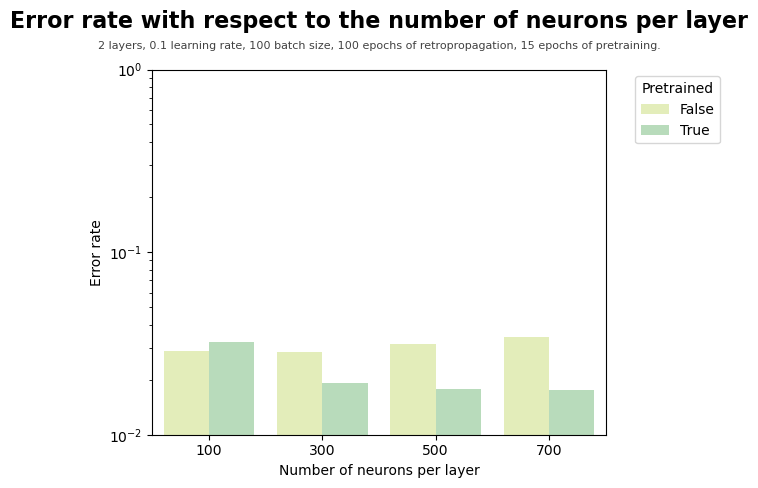

In [16]:
sns.set_palette(sns.color_palette("YlGnBu"))
fig, ax = plt.subplots(figsize=(7,5))
sns.barplot(
    x='nb_neurons',
    y='accuracy',
    hue='pretrained',
    data=df,
    ax=ax
)

# make adjustments
ax.set_xlabel('Number of neurons per layer')
ax.set_ylabel('Error rate')

ax.set_yscale('log')

# set y scale between 0 and 1
ax.set_ylim([0.01, 1])

ax.text(x=0.5, y=1.1, s='Error rate with respect to the number of neurons per layer', fontsize=16, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
ax.text(x=0.5, y=1.05, s=f"{nb_layers} layers, {learning_rate} learning rate, {batch_size} batch size, {nb_epochs_retropropagation} epochs of retropropagation, {nb_epochs_pretraining} epochs of pretraining.", fontsize=8, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)

h,l = ax.get_legend_handles_labels()
ax.legend(h[:4],l[:4], bbox_to_anchor=(1.05, 1), loc=2, title="Pretrained")

fig.tight_layout()
plt.show()

## Étude de l'impact de la taille du train set sur le taux d'erreur


##### size = 1000


Retropropagation | Cross entropy loss: 2.3028 | Epoch: 100%|██████████| 30/30 [00:01<00:00, 21.69it/s]
DBN Training | RBM: 100%|██████████| 2/2 [00:01<00:00,  1.92it/s]
Retropropagation | Cross entropy loss: 0.6497 | Epoch: 100%|██████████| 30/30 [00:01<00:00, 20.97it/s]


Error rate without pretraining: 0.8968
Error rate with pretraining: 0.2204

##### size = 3000


Retropropagation | Cross entropy loss: 2.3049 | Epoch: 100%|██████████| 30/30 [00:04<00:00,  7.24it/s]
DBN Training | RBM: 100%|██████████| 2/2 [00:03<00:00,  1.61s/it]
Retropropagation | Cross entropy loss: 0.3337 | Epoch: 100%|██████████| 30/30 [00:04<00:00,  6.73it/s]


Error rate without pretraining: 0.8865
Error rate with pretraining: 0.1017

##### size = 7000


Retropropagation | Cross entropy loss: 2.2483 | Epoch: 100%|██████████| 30/30 [00:09<00:00,  3.09it/s]
DBN Training | RBM: 100%|██████████| 2/2 [00:07<00:00,  3.69s/it]
Retropropagation | Cross entropy loss: 0.2246 | Epoch: 100%|██████████| 30/30 [00:09<00:00,  3.22it/s]


Error rate without pretraining: 0.717
Error rate with pretraining: 0.0712

##### size = 10000


Retropropagation | Cross entropy loss: 1.2294 | Epoch: 100%|██████████| 30/30 [00:12<00:00,  2.48it/s]
DBN Training | RBM: 100%|██████████| 2/2 [00:11<00:00,  5.54s/it]
Retropropagation | Cross entropy loss: 0.1996 | Epoch: 100%|██████████| 30/30 [00:13<00:00,  2.15it/s]


Error rate without pretraining: 0.4459
Error rate with pretraining: 0.0611

##### size = 30000


Retropropagation | Cross entropy loss: 0.3192 | Epoch: 100%|██████████| 30/30 [00:39<00:00,  1.33s/it]
DBN Training | RBM: 100%|██████████| 2/2 [00:29<00:00, 14.87s/it]
Retropropagation | Cross entropy loss: 0.1237 | Epoch: 100%|██████████| 30/30 [00:35<00:00,  1.17s/it]


Error rate without pretraining: 0.0982
Error rate with pretraining: 0.041

##### size = 60000


Retropropagation | Cross entropy loss: 0.1437 | Epoch: 100%|██████████| 30/30 [01:09<00:00,  2.31s/it]
DBN Training | RBM: 100%|██████████| 2/2 [01:01<00:00, 30.59s/it]
Retropropagation | Cross entropy loss: 0.0919 | Epoch: 100%|██████████| 30/30 [01:07<00:00,  2.26s/it]


Error rate without pretraining: 0.0461
Error rate with pretraining: 0.0306


In [18]:
import pandas as pd

# create a dataframe with columns nb_layers, accuracy, time, pretrained
data = []
for i in range(len(sizes)):
    data.append([sizes[i], accuracies[i], times[i], False])
    data.append([sizes[i], accuracies_pretrained[i], times_pretrained[i], True])
df = pd.DataFrame(data, columns=["nb_neurons", "accuracy", "time", "pretrained"])
df.head()

,nb_neurons,accuracy,time,pretrained
0,1000,0.8968,1.385231,False
1,1000,0.2204,2.479366,True
2,3000,0.8865,4.147337,False
3,3000,0.1017,7.687806,True
4,7000,0.7170,9.710188,False


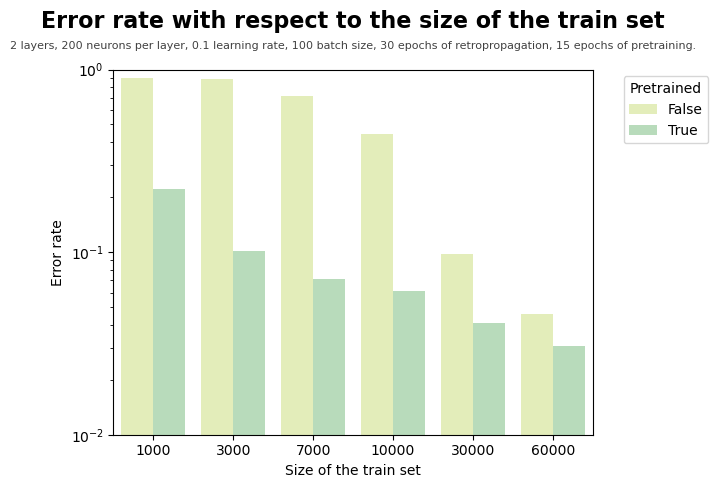

In [19]:
sns.set_palette(sns.color_palette("YlGnBu"))
fig, ax = plt.subplots(figsize=(7,5))
sns.barplot(
    x='nb_neurons',
    y='accuracy',
    hue='pretrained',
    data=df,
    ax=ax
)

# make adjustments
ax.set_xlabel('Size of the train set')
ax.set_ylabel('Error rate')

# log scale
ax.set_yscale('log')

# set y scale between 0 and 1
ax.set_ylim([0.01, 1])

ax.text(x=0.5, y=1.1, s='Error rate with respect to the size of the train set', fontsize=16, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
ax.text(x=0.5, y=1.05, s=f"{nb_layers} layers, {nb_neurons} neurons per layer, {learning_rate} learning rate, {batch_size} batch size, {nb_epochs_retropropagation} epochs of retropropagation, {nb_epochs_pretraining} epochs of pretraining.", fontsize=8, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)

h,l = ax.get_legend_handles_labels()
ax.legend(h[:4],l[:4], bbox_to_anchor=(1.05, 1), loc=2, title="Pretrained")

fig.tight_layout()
plt.show()

## Losses plots

In [14]:
nb_layers = 2
nb_neurons = 200
learning_rate = 0.1
batch_size = 1000
nb_epochs_retropropagation = 200
nb_epochs_pretraining = 15

accuracies = []
accuracies_pretrained = []

dnn = DNN([784] + [nb_neurons for _ in range(nb_layers)] + [10])
dnn_pretrained = copy.deepcopy(dnn)

losses = dnn.retropropagation(X_train, y_train, learning_rate, batch_size, nb_epochs_retropropagation, verbose=False)

dnn_pretrained.pretrain(X_train, learning_rate, batch_size, nb_epochs_pretraining, verbose=False)
losses_pretrained = dnn_pretrained.retropropagation(X_train, y_train, learning_rate, batch_size, nb_epochs_retropropagation, verbose=False)

acc = dnn.test(X_test, y_test)
acc_pretrained = dnn_pretrained.test(X_test, y_test)

print(f"Error rate without pretraining: {acc}")
print(f"Error rate with pretraining: {acc_pretrained}")

accuracies.append(acc)
accuracies_pretrained.append(acc_pretrained)

Retropropagation | Cross entropy loss: 0.2245 | Epoch: 100%|██████████| 200/200 [07:15<00:00,  2.18s/it]
DBN Training | RBM: 100%|██████████| 2/2 [01:18<00:00, 39.00s/it]
Retropropagation | Cross entropy loss: 0.1240 | Epoch: 100%|██████████| 200/200 [07:34<00:00,  2.27s/it]


Error rate without pretraining: 0.0693
Error rate with pretraining: 0.0384


In [5]:
losses

[0.7172482266176199,
 0.4397070205608443,
 0.36504021037825957,
 0.32962727415759707,
 0.3066067013620548,
 0.2889376357071288,
 0.2740719585865538,
 0.26097026239986615,
 0.24917772029373192,
 0.2384477060628813,
 0.22860872904029927,
 0.21952822790590804,
 0.211102055785904,
 0.20324868434931323,
 0.19590409414665771,
 0.18901715563693533,
 0.18254586798337585,
 0.17645461737792,
 0.17071235463302453,
 0.16529146733848296,
 0.16016711323016528,
 0.15531682312720316,
 0.15072023836061196,
 0.14635890297299714,
 0.14221607348820117,
 0.13827653460432549,
 0.13452642139598123,
 0.13095305323945608,
 0.12754478544056733,
 0.12429088300623241]

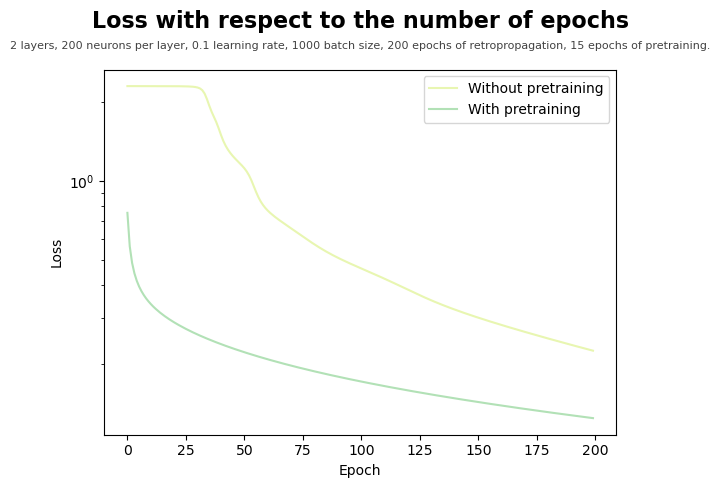

In [15]:
# plot losses using seaborn

sns.set_palette(sns.color_palette("YlGnBu"))
fig, ax = plt.subplots(figsize=(7,5))
sns.lineplot(
    x=range(len(losses)),
    y=losses,
    ax=ax,
    label="Without pretraining"
)
sns.lineplot(
    x=range(len(losses_pretrained)),
    y=losses_pretrained,
    ax=ax,
    label="With pretraining"
)

# make adjustments
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

# log scale
ax.set_yscale('log')

# show figure
ax.text(x=0.5, y=1.1, s='Loss with respect to the number of epochs', fontsize=16, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
ax.text(x=0.5, y=1.05, s=f"{nb_layers} layers, {nb_neurons} neurons per layer, {learning_rate} learning rate, {batch_size} batch size, {nb_epochs_retropropagation} epochs of retropropagation, {nb_epochs_pretraining} epochs of pretraining.", fontsize=8, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)

fig.tight_layout()
plt.show()

## Study of the effect of the batch size

In [24]:
nb_layer = 3
nb_neurons = 200
learning_rate = 0.1
batch_sizes = [10, 100, 1000, 10000]
nb_epochs_retropropagation = 100
nb_epochs_pretraining = 15

accuracies = []
accuracies_pretrained = []
times = []
times_pretrained = []
list_losses = []
list_losses_pretrained = []

for batch_size in batch_sizes:
    print(f"\n##### batch_size = {batch_size}")
    dnn = DNN([784] + [nb_neurons for i in range(nb_layer)] + [10])
    dnn_pretrained = copy.deepcopy(dnn)

    acc, acc_pretrained, pretraining_time, retropropagation_time, retropropagation_time_pretrained, losses, losses_pretrained = train_and_test(
        dnn,
        dnn_pretrained,
        X_train,
        y_train,
        X_test,
        y_test,
        learning_rate,
        batch_size,
        nb_epochs_pretraining,
        nb_epochs_retropropagation,
    )

    accuracies.append(acc)
    accuracies_pretrained.append(acc_pretrained)
    times.append(retropropagation_time)
    times_pretrained.append(pretraining_time + retropropagation_time_pretrained)
    list_losses.append(losses)
    list_losses_pretrained.append(losses_pretrained)



##### batch_size = 10


Retropropagation | Cross entropy loss: 0.0002 | Epoch: 100%|██████████| 100/100 [19:37<00:00, 11.78s/it]


Error rate without pretraining: 0.0323
Error rate with pretraining: 0.9108

##### batch_size = 100


Retropropagation | Cross entropy loss: 0.0671 | Epoch: 100%|██████████| 100/100 [06:38<00:00,  3.98s/it]


Error rate without pretraining: 0.041
Error rate with pretraining: 0.899

##### batch_size = 1000


Retropropagation | Cross entropy loss: 2.3015 | Epoch: 100%|██████████| 100/100 [04:51<00:00,  2.91s/it]


Error rate without pretraining: 0.8972
Error rate with pretraining: 0.8991

##### batch_size = 10000


Retropropagation | Cross entropy loss: 2.3013 | Epoch: 100%|██████████| 100/100 [05:11<00:00,  3.11s/it]


Error rate without pretraining: 0.8865
Error rate with pretraining: 0.8865


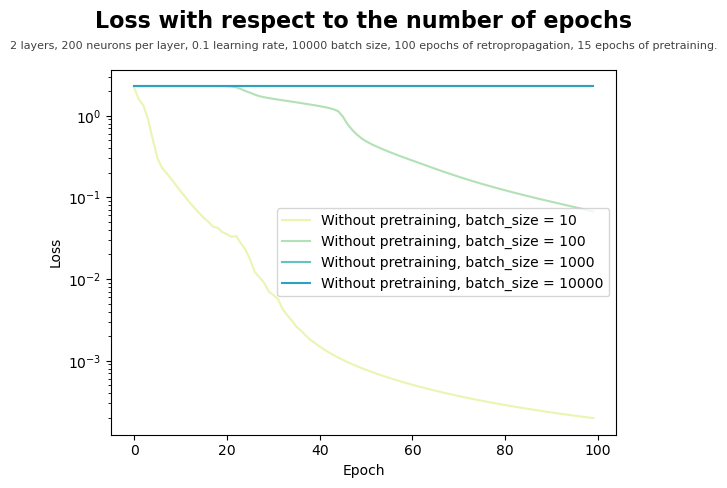

In [25]:
# Plot losses
sns.set_palette(sns.color_palette("YlGnBu"))

fig, ax = plt.subplots(figsize=(7,5))
for i, batch_size in enumerate(batch_sizes):
    sns.lineplot(
        x=range(len(list_losses[i])),
        y=list_losses[i],
        ax=ax,
        label=f"Without pretraining, batch_size = {batch_size}"
    )
    # sns.lineplot(
    #     x=range(len(list_losses_pretrained[i])),
    #     y=list_losses_pretrained[i],
    #     ax=ax,
    #     label=f"With pretraining, batch_size = {batch_size}"
    # )

# make adjustments
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

# log scale
ax.set_yscale('log')

# show figure
ax.text(x=0.5, y=1.1, s='Loss with respect to the number of epochs', fontsize=16, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
ax.text(x=0.5, y=1.05, s=f"{nb_layers} layers, {nb_neurons} neurons per layer, {learning_rate} learning rate, {batch_size} batch size, {nb_epochs_retropropagation} epochs of retropropagation, {nb_epochs_pretraining} epochs of pretraining.", fontsize=8, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)

fig.tight_layout()
plt.show()